In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import itertools

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
from matplotlib import pyplot as plt

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [7]:
from words import *

# Get data

In [8]:
MAX_LEN = 15

In [9]:
langs = sorted(['en', 'de', 'fr', 'it', 'sp'])
langs

['de', 'en', 'fr', 'it', 'sp']

In [10]:
idx_to_lang = dict(enumerate(langs))
lang_to_idx = {lang: idx for idx, lang in idx_to_lang.items()}

In [11]:
print(idx_to_lang)
print(lang_to_idx)

{0: 'de', 1: 'en', 2: 'fr', 3: 'it', 4: 'sp'}
{'de': 0, 'en': 1, 'fr': 2, 'it': 3, 'sp': 4}


In [12]:
filepaths = get_filepaths(*langs)
df = read_data(filepaths)
df = filter_data(df, min_len=4, max_len=MAX_LEN, min_freq=5)
df.language = df.language.str.slice(0, 2)

In [13]:
df.head()

,word,freq,language
37,wurde,1463,de
46,sich,1066,de
47,eine,1049,de
53,auch,662,de
55,nach,653,de


In [14]:
df.groupby('language').size()

language
de    3104
en    4613
fr    4079
it    4480
sp    4312
dtype: int64

### Remove duplicate words across languages

In [15]:
joined = df.merge(df, on=['word'])
joined = joined[joined.language_x != joined.language_y]
duplicate_words = list(set(joined.word))
print(duplicate_words)

['principalmente', 'numero', 'windows', 'universitario', 'jersey', 'reduction', 'produce', 'copies', 'orden', 'director', 'marzo', 'instruments', 'expression', 'homer', 'marie', 'rock', 'europea', 'lire', 'grace', 'libro', 'station', 'biografia', 'vive', 'chicago', 'forces', 'forme', 'application', 'execution', 'romano', 'actions', 'factor', 'metal', 'cargo', 'categoria', 'violence', 'individuo', 'grosse', 'social', 'poste', 'role', 'army', 'walter', 'firmo', 'stuttgart', 'formato', 'formula', 'superior', 'guerre', 'flotte', 'santa', 'forte', 'civile', 'album', 'convento', 'simbolo', 'street', 'hugo', 'strict', 'modo', 'extreme', 'gigante', 'durante', 'hospital', 'pure', 'federale', 'motor', 'familiar', 'trouble', 'expedition', 'brain', 'north', 'masse', 'jordan', 'table', 'palais', 'fall', 'mayor', 'basa', 'analyse', 'economia', 'film', 'place', 'louis', 'direction', 'visible', 'alta', 'centrale', 'documents', 'poco', 'representations', 'capitan', 'seconde', 'mario', 'schema', 'poesia

In [16]:
df = df[~df.word.isin(duplicate_words)]

In [17]:
df.groupby('language').size()

language
de    2795
en    3606
fr    3159
it    3694
sp    3482
dtype: int64

### Remove duplicate words within languages

In [18]:
df = df.drop_duplicates('word')

In [19]:
assert len(df.word) == len(set(df.word))

In [20]:
df.groupby('language').size()

language
de    2623
en    3387
fr    2922
it    3483
sp    3199
dtype: int64

### Get train and validation indices

In [21]:
df = df.reset_index(drop=True)

In [22]:
train_idxs, val_idxs = train_test_split(df.index.tolist(), train_size=0.5, random_state=1)

/home/quentin/anaconda3/envs/rnn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
by_word_length = lambda i: len(df.iloc[i].word)
train_idxs = sorted(train_idxs, key=by_word_length, reverse=True)
val_idxs = sorted(val_idxs, key=by_word_length, reverse=True)

### Get vocabulary

In [24]:
words = df.word.tolist()

In [25]:
vocab = ['\0'] + sorted(list(set(''.join(words))))
n_vocab = len(vocab)
''.join(vocab)

'\x00abcdefghijklmnopqrstuvwxyz'

In [26]:
idx_to_char = dict(enumerate(vocab))
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

### Shape padded data

In [27]:
words_idxs = [[char_to_idx[char] for char in word] for word in words]
#words_idxs = sorted(words_idxs, key=len, reverse=True)

In [28]:
words_len = list(map(len, words_idxs))

In [29]:
print(words_idxs[:2], words_idxs[-2:])
print(words_len[:2], words_len[-2:])

[[23, 21, 18, 4, 5], [19, 9, 3, 8]] [[22, 15, 12, 15, 14, 20, 1, 18, 9], [25, 1, 18, 4]]
[5, 4] [9, 4]


In [30]:
data = torch.zeros((max(words_len), len(words_len))).long()
for i, word_idxs in enumerate(words_idxs):
    data[:len(word_idxs), i] = torch.Tensor(word_idxs)
data

tensor([[23, 19,  5,  ..., 22, 22, 25],
        [21,  9,  9,  ..., 15, 15,  1],
        [18,  3, 14,  ..., 12, 12, 18],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])

In [31]:
train_data, val_data = data[:, train_idxs], data[:, val_idxs]
train_data.size(), val_data.size()

(torch.Size([15, 7807]), torch.Size([15, 7807]))

In [32]:
lens = torch.Tensor(words_len).long()

In [33]:
train_lens, val_lens = lens[train_idxs], lens[val_idxs]
train_lens.size(), val_lens.size()

(torch.Size([7807]), torch.Size([7807]))

### Shape labels

In [34]:
languages = df.language.tolist()

In [35]:
languages_idxs = [lang_to_idx[language] for language in languages]

In [36]:
labels = torch.Tensor(languages_idxs).long()

In [37]:
train_labels, val_labels = labels[train_idxs], labels[val_idxs]
train_labels.size(), val_labels.size()

(torch.Size([7807]), torch.Size([7807]))

### Create batches of (data, lens, labels)

In [38]:
def get_batches(data, lens, labels, bs):
    batch_size = bs
    for i in range(0, data.shape[1], bs):
        data_batch = data[:, i:i + bs]
        lens_batch = lens[i:i + bs]
        labels_batch = labels[i:i + bs]
        yield data_batch, lens_batch, labels_batch

In [39]:
# Start of dataset, longest words

batches = get_batches(data, lens, labels, bs=3)

data_batch, lens_batch, labels_batch = next(batches)
print(f'data:\n{data_batch}')
print(f'lens:\n{lens_batch}')
print(f'labels:\n{labels_batch}')
print()

data:
tensor([[23, 19,  5],
        [21,  9,  9],
        [18,  3, 14],
        [ 4,  8,  5],
        [ 5,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]])
lens:
tensor([5, 4, 4])
labels:
tensor([0, 0, 0])



In [40]:
# End of dataset, shortest words

for data_batch, lens_batch, labels_batch in get_batches(data, lens, labels, bs=3):
    pass

print(f'data:\n{data_batch}')
print(f'lens:\n{lens_batch}')
print(f'labels:\n{labels_batch}')
print()

data:
tensor([[22, 25],
        [15,  1],
        [12, 18],
        [15,  4],
        [14,  0],
        [20,  0],
        [ 1,  0],
        [18,  0],
        [ 9,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0]])
lens:
tensor([9, 4])
labels:
tensor([3, 3])



# Model

In [41]:
class LSTM(nn.Module):
    def __init__(self, bs, n_vocab, n_fac, n_hidden, n_layers, dropout=0):

        super().__init__()

        self.bs = bs
        self.n_layers = n_layers
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(n_fac, n_hidden, n_layers, dropout=dropout)
        self.e = nn.Embedding(n_vocab, n_fac)
        self.output_weights = nn.Linear(n_hidden, 5)

        self.init_hidden(bs)

    def forward(self, data, lens):
        
        if data.shape[1] != self.bs:
            self.init_hidden(data.shape[1])
        
        input = self.e(data)

        hidden_state = self.hidden_state
        cell_state = self.cell_state

        packed_input = pack_padded_sequence(input, lens)
        packed_output, (hidden_state, cell_state) = self.lstm(packed_input, (hidden_state, cell_state))
        output = pad_packed_sequence(packed_output)[0]
        output = torch.stack([output[lens[i] - 1, i] for i in range(output.shape[1])])

        # Throw away state histories
        self.hidden_state = Variable(hidden_state)
        self.cell_state = Variable(cell_state)
        
        # Get output
        output = self.output_weights(output)
        output = F.log_softmax(output, dim=-1)

        return output

    def init_hidden(self, bs):
        self.hidden_state = torch.zeros([self.n_layers, bs, self.n_hidden])
        self.cell_state = torch.zeros([self.n_layers, bs, self.n_hidden])

In [42]:
bs = 128
n_fac = 13
n_hidden = 30
n_layers = 1
dropout = 0

In [43]:
lstm = LSTM(bs, n_vocab, n_fac, n_hidden, n_layers, dropout)

In [44]:
epochs = 10
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(lstm.parameters(), 1e-2)

In [45]:
for epoch in range(1, epochs + 1):

    lstm.init_hidden(bs)

    train_loss_sum, train_batches_nb = 0, 0
    train_batches = get_batches(train_data, train_lens, train_labels, bs)
    for i, (data_batch, lens_batch, labels_batch) in enumerate(train_batches, 1):
        preds_batch = lstm(data_batch, lens_batch)
        optimizer.zero_grad()
        loss = criterion(preds_batch, labels_batch)
        train_loss_sum, train_batches_nb = train_loss_sum + loss.item(), train_batches_nb + 1
        loss.backward()
        optimizer.step()
    train_loss = train_loss_sum / train_batches_nb

    lstm.init_hidden(bs)

    val_preds = lstm(val_data, val_lens)
    val_loss = criterion(val_preds, val_labels)
    val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean().item()

    print(f'epoch: {epoch:3d}   train_loss: {train_loss:.2f}   val_loss: {val_loss:.2f}'
          f'   accuracy: {val_accuracy:.2f}')

epoch:   1   train_loss: 1.21   val_loss: 0.99   accuracy: 0.55
epoch:   2   train_loss: 0.89   val_loss: 0.86   accuracy: 0.64
epoch:   3   train_loss: 0.79   val_loss: 0.79   accuracy: 0.68
epoch:   4   train_loss: 0.72   val_loss: 0.75   accuracy: 0.70
epoch:   5   train_loss: 0.67   val_loss: 0.74   accuracy: 0.70
epoch:   6   train_loss: 0.63   val_loss: 0.74   accuracy: 0.70
epoch:   7   train_loss: 0.60   val_loss: 0.74   accuracy: 0.70
epoch:   8   train_loss: 0.57   val_loss: 0.74   accuracy: 0.71
epoch:   9   train_loss: 0.55   val_loss: 0.74   accuracy: 0.71
epoch:  10   train_loss: 0.52   val_loss: 0.74   accuracy: 0.72


### Predict and enrich validation dataset for analysis

In [46]:
df_val = df.iloc[val_idxs].reset_index(drop=True)

In [47]:
df_val['language_id'] = val_labels.numpy()

In [48]:
preds_dummy = lstm(val_data, val_lens).exp().detach().numpy()
preds = np.argmax(preds_dummy, axis=1)
probas = np.max(preds_dummy, axis=1)
df_val['pred_id'] = preds
df_val['probas'] = probas

In [49]:
df_val['pred'] = df_val['pred_id'].map(dict(enumerate(langs)))

### Results analysis

In [50]:
# Most confident predictions
df_val.sort_values('probas', ascending=False).head(10)

,word,freq,language,language_id,pred_id,probas,pred
6668,asked,20,en,1,1,0.999880,en
2076,initiated,5,en,1,1,0.999763,en
4010,settled,14,en,1,1,0.999668,en
1913,discussed,6,en,1,1,0.999663,en
5775,showed,19,en,1,1,0.999628,en
6780,hired,14,en,1,1,0.999628,en
1675,advocated,6,en,1,1,0.999598,en
5382,cooked,9,en,1,1,0.999565,en
339,incorporated,6,en,1,1,0.999481,en
1078,translated,10,en,1,1,0.999468,en


In [51]:
# Least confident predictions
df_val.sort_values('probas').head(10)

,word,freq,language,language_id,pred_id,probas,pred
5286,sortir,15,fr,2,1,0.255531,en
937,respingere,5,it,3,3,0.263520,it
5709,svolse,5,it,3,1,0.277349,en
4235,impulse,5,en,1,4,0.279007,sp
4308,inverse,16,fr,2,4,0.280574,sp
4096,signale,6,de,0,1,0.285774,en
4571,concern,11,en,1,4,0.288776,sp
7259,axis,9,en,1,0,0.290499,de
2963,operator,5,en,1,1,0.290795,en
7651,doce,13,sp,4,4,0.291871,sp


In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [53]:
cm = confusion_matrix(df_val['language'], df_val['pred'])

Confusion matrix, without normalization
[[ 935  243   98   24   37]
 [  77 1339  215   34   57]
 [  48  367  933   55   65]
 [  17   38  126 1293  253]
 [  16  127   81  212 1117]]


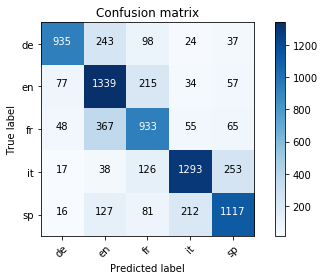

In [54]:
plot_confusion_matrix(cm, langs)

Normalized confusion matrix
[[0.69932685 0.18175019 0.07329843 0.01795064 0.0276739 ]
 [0.04471545 0.7775842  0.12485482 0.01974448 0.03310105]
 [0.03269755 0.25       0.63555858 0.03746594 0.04427793]
 [0.00984366 0.02200347 0.07295889 0.74869716 0.14649682]
 [0.01030264 0.08177721 0.05215712 0.13650998 0.71925306]]


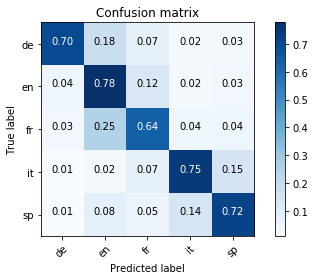

In [55]:
plot_confusion_matrix(cm, langs, normalize=True)